In [1]:
from torchvision.datasets import VOCDetection
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw

In [2]:
IMG_SIZE=448
S=7
C=20


# VOC数据集

In [3]:
voc_ds=VOCDetection(root='./data',year='2012',image_set='train',download=True)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


{'annotation': {'folder': 'VOC2012', 'filename': '2008_000008.jpg', 'source': {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}, 'size': {'width': '500', 'height': '442', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'horse', 'pose': 'Left', 'truncated': '0', 'occluded': '1', 'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'}, 'difficult': '0'}, {'name': 'person', 'pose': 'Unspecified', 'truncated': '1', 'occluded': '0', 'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'}, 'difficult': '0'}]}}


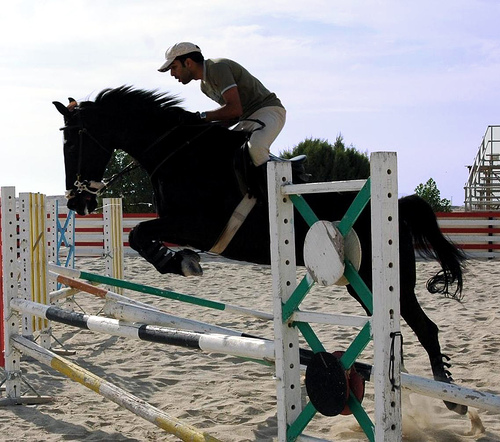

In [4]:
img,label=voc_ds[0]
print(label)
img

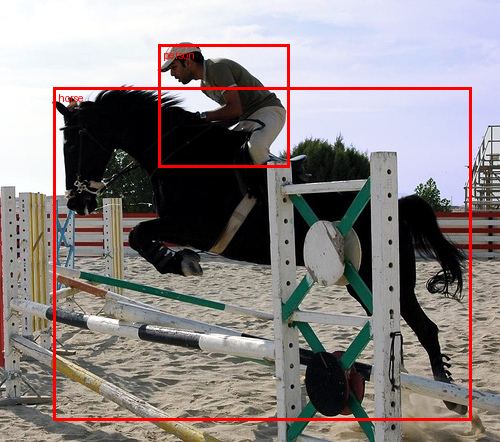

In [5]:
# 画框工具
draw=ImageDraw.Draw(img)

# 遍历每个object
for obj in label['annotation']['object']:
    box=obj['bndbox']
    draw.rectangle([int(box['xmin']),int(box['ymin']),int(box['xmax']),int(box['ymax'])],
                   outline='red',
                   width=3)
    draw.text([int(box['xmin'])+5,int(box['ymin'])+5],obj['name'],fill='red')

img

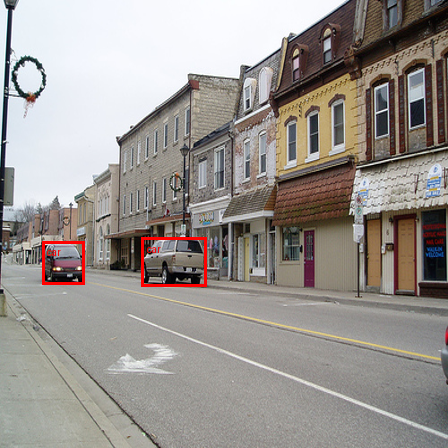

In [6]:
img,label=voc_ds[4]

scaled_img=img.resize((IMG_SIZE,IMG_SIZE)) # 缩放至YoloV1的尺寸

# 缩放比
x_scale=IMG_SIZE/img.width
y_scale=IMG_SIZE/img.height

draw=ImageDraw.Draw(scaled_img)
for obj in label['annotation']['object']:
    box=obj['bndbox']
    draw.rectangle([int(box['xmin'])*x_scale,int(box['ymin'])*y_scale,int(box['xmax'])*x_scale,int(box['ymax'])*y_scale],
                   outline='red',
                   width=3)
    draw.text([int(box['xmin'])*x_scale+5,int(box['ymin'])*y_scale+5],obj['name'],fill='red')

scaled_img

# Dataset设计

In [7]:
# 引入dataset基类
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch

In [8]:
class YoloVOCDataset(Dataset):
    def __init__(self,voc_ds):
        super().__init__()
        self.voc_ds=voc_ds
        
        classdict=set()
        for _,label in self.voc_ds:
            for obj in label['annotation']['object']:
                classdict.add(obj['name'])
        self.id2name={i:c for i,c in enumerate(classdict)}
        self.name2id={c:i for i,c in self.id2name.items()}
    
    def __getitem__(self,index):
        img,label=self.voc_ds[index]
        
        scaled_img=img.resize((IMG_SIZE,IMG_SIZE)) 
    
        x_scale=IMG_SIZE/img.width
        y_scale=IMG_SIZE/img.height
        grid_size=IMG_SIZE//S
        
        x=ToTensor()(scaled_img)
        y=torch.zeros(S,S,10+C)
        
        for obj in label['annotation']['object']:
            box=obj['bndbox']
            classid=self.name2id[obj['name']]
            
            # normal coordinates
            xmin,ymin,xmax,ymax=int(box['xmin'])*x_scale,int(box['ymin'])*y_scale,int(box['xmax'])*x_scale,int(box['ymax'])*y_scale
            xcenter,ycenter=(xmin+xmax)/2,(ymin+ymax)/2
            width,height=xmax-xmin,ymax-ymin
            grid_i,grid_j=int(xcenter//grid_size),int(ycenter//grid_size)
            
            # yolo coordinates
            xcenter,ycenter=xcenter%grid_size/grid_size,ycenter%grid_size/grid_size
            width,height=width/IMG_SIZE,height/IMG_SIZE
            
            # targets
            y[grid_i,grid_j,0:5]=y[grid_i,grid_j,5:10]=torch.tensor([xcenter,ycenter,width,height,1])   # x,y,w,h,c
            y[grid_i,grid_j,10:]=torch.zeros(20)
            y[grid_i,grid_j,10+classid]=1
        return x,y
    
    def __len__(self):
        return len(self.voc_ds)

In [9]:
ds=YoloVOCDataset(voc_ds)

In [10]:
x,y=ds[0]
x.shape,y.shape

(torch.Size([3, 448, 448]), torch.Size([7, 7, 30]))

# YoloV1 Model

In [11]:
from torch import nn 
import torch
from torchvision.models import resnet50,ResNet50_Weights

device='cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
class YoloV1(nn.Module):
    def __init__(self):
        super().__init__()

        if 0:
            self.backbone=nn.Sequential(
                # 448*448
                nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3), 
                nn.LeakyReLU(0.1),
                nn.MaxPool2d(kernel_size=2,stride=2),
                
                # 112*112
                nn.Conv2d(in_channels=64,out_channels=192,kernel_size=3,stride=1,padding=1),
                nn.LeakyReLU(0.1),
                nn.MaxPool2d(kernel_size=2,stride=2),
                
                # 56*56
                nn.Conv2d(in_channels=192,out_channels=128,kernel_size=1,stride=1),
                nn.LeakyReLU(0.1),
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.LeakyReLU(0.1),
                nn.Conv2d(in_channels=256,out_channels=256,kernel_size=1,stride=1),
                nn.LeakyReLU(0.1),
                nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),
                nn.LeakyReLU(0.1),
                nn.MaxPool2d(kernel_size=2,stride=2),
                
                # 28*28
                *[
                    nn.Conv2d(in_channels=512,out_channels=256,kernel_size=1,stride=1),
                    nn.LeakyReLU(0.1),
                    nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),
                    nn.LeakyReLU(0.1),
                ]*4,
                nn.Conv2d(in_channels=512,out_channels=512,kernel_size=1,stride=1),
                nn.LeakyReLU(0.1),
                nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,stride=1,padding=1),
                nn.LeakyReLU(0.1),
                nn.MaxPool2d(kernel_size=2,stride=2),
                
                # 14*14
                *[
                    nn.Conv2d(in_channels=1024,out_channels=512,kernel_size=1,stride=1),
                    nn.LeakyReLU(0.1),
                    nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,stride=1,padding=1),
                    nn.LeakyReLU(0.1),
                ]*2,
                nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1),
                nn.LeakyReLU(0.1),
                nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=2,padding=1),
                nn.LeakyReLU(0.1),
                
                # 7*7
                nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1),
                nn.LeakyReLU(0.1),
                nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1), # (batch,1024,7,7)
                nn.LeakyReLU(0.1),
            )
        else:
            resnet=resnet50(ResNet50_Weights.DEFAULT) # (batch,2048,14,14)
            self.backbone=nn.Sequential(
                *list(resnet.children())[:-2],
                nn.Conv2d(in_channels=2048,out_channels=1024,kernel_size=3,padding=1) # (batch,1024,14,14)
            )
            for param in self.backbone.parameters():
                param.requires_grad=False
            
        self.head=nn.Sequential(
            nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=2,padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1), # (batch,1024,7,7)
            nn.LeakyReLU(0.1),
            
            nn.Flatten(),
            nn.Linear(in_features=S*S*1024,out_features=4096),
            nn.Dropout(),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=4096,out_features=S*S*(10+C)),
            nn.Sigmoid(),
        )
        
    def forward(self,x): # x:(batch,3,448,448)
        y=self.backbone(x) # (batch,1024,7,7)
        y=self.head(y) # (batch,S*S*(10+C))
        return y.view(-1,S,S,10+C)

In [13]:
model=YoloV1().to(device)
x,y=ds[0]
outputs=model(x.unsqueeze(0).to(device))
outputs.shape

c:\Users\owen\miniconda3\envs\yolov1\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


torch.Size([1, 7, 7, 30])

# Train

In [14]:
from torch.utils.data.dataloader import DataLoader
from torch import optim
import os 

In [15]:
def compute_iou(grid_row,grid_col,xywh_a,xywh_b):
    grid_size=IMG_SIZE//S
    
    # yolo coordinates
    xcenter_a,ycenter_a,w_a,h_a=xywh_a
    xcenter_b,ycenter_b,w_b,h_b=xywh_b
    
    # normal coordinates
    xcenter_a,ycenter_a=(grid_col+xcenter_a)*grid_size,(grid_row+ycenter_a)*grid_size
    w_a,h_a=w_a*IMG_SIZE,h_a*IMG_SIZE
    xcenter_b,ycenter_b=(grid_col+xcenter_b)*grid_size,(grid_row+ycenter_b)*grid_size
    w_b,h_b=w_b*IMG_SIZE,h_b*IMG_SIZE
    
    # border
    xmin_a,xmax_a,ymin_a,ymax_a=xcenter_a-w_a/2,xcenter_a+w_a/2,ycenter_a-h_a/2,ycenter_a+h_a/2
    xmin_b,xmax_b,ymin_b,ymax_b=xcenter_b-w_b/2,xcenter_b+w_b/2,ycenter_b-h_b/2,ycenter_b+h_b/2
    
    # IOU
    inter_xmin=max(xmin_a,xmin_b)
    inter_xmax=min(xmax_a,xmax_b)
    inter_ymin=max(ymin_a,ymin_b)
    inter_ymax=min(ymax_a,ymax_b)
    if inter_xmax<inter_xmin or inter_ymax<inter_ymin:
        return 0

    inter_area=(inter_xmax-inter_xmin)*(inter_ymax-inter_ymin) # 交集
    union_area=w_a*h_a+w_b*h_b-inter_area # 并集
    return inter_area/union_area # IOU

In [ ]:
lambda_coord=5
lambda_noojb=0.5

model=YoloV1().to(device)

# load checkpoint
try:
    checkpoint=torch.load('checkpoint.pth')
    model.load_state_dict(checkpoint['model'])
except:pass

dataloader=DataLoader(ds,batch_size=32,shuffle=True)
optimizer=optim.Adam([param for param in model.parameters() if param.requires_grad],lr=3e-5)

model.train()

for epoch in range(50):
    print(f'epoch={epoch}')
    for batch_x,batch_y in dataloader:
        batch_x,batch_y=batch_x.to(device),batch_y.to(device)
        batch_output=model(batch_x)
        
        loss=torch.tensor(0)
        for i in range(len(batch_x)):
            x=batch_x[i]
            y=batch_y[i]
            output=batch_output[i]
            # foreach grid 
            for row in range(S):    
                for col in range(S):
                    pred_grid=output[row,col] 
                    target_grid=y[row,col]
                    if not target_grid[4]>0: # no object in this grid
                        loss_c_noobj=(pred_grid[4])**2+(pred_grid[9])**2 # no object in grid,so target c is 0
                        loss=loss+lambda_noojb*loss_c_noobj
                        continue 
                    # IOU
                    iou_bbox1=compute_iou(row,col,pred_grid[:4],target_grid[:4])
                    iou_bbox2=compute_iou(row,col,pred_grid[5:9],target_grid[:4])
                    # 取IOU大的预测框的x,y,w,h,c
                    if iou_bbox1>iou_bbox2:
                        xywh=pred_grid[:4]
                        c_obj,c_noobj=pred_grid[4],pred_grid[9]
                        iou_obj,iou_noobj=iou_bbox1,iou_bbox2
                    else:
                        xywh=pred_grid[5:9]
                        c_obj,c_noobj=pred_grid[9],pred_grid[4]
                        iou_obj,iou_noobj=iou_bbox2,iou_bbox1
                    loss_xywh=(xywh[0]-target_grid[0])**2+(xywh[1]-target_grid[1])**2+(torch.sqrt(xywh[2])-torch.sqrt(target_grid[2]))**2+(torch.sqrt(xywh[3])-torch.sqrt(target_grid[3]))**2
                    loss_c_obj=(c_obj-iou_obj)**2
                    loss_c_noobj=(c_noobj-iou_noobj)**2
                    loss_class=((pred_grid[10:]-target_grid[10:])**2).sum()
                    loss=loss+loss_xywh*lambda_coord+loss_c_obj+loss_c_noobj*lambda_noojb+loss_class
        loss=loss/len(batch_x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item())
    torch.save({'model':model.state_dict()},'.checkpoint.pth')
    os.replace('.checkpoint.pth','checkpoint.pth')
        

c:\Users\owen\miniconda3\envs\yolov1\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


epoch=0
2.4874632358551025
2.869473695755005
3.1331186294555664
2.7714927196502686
2.8544821739196777
2.1150524616241455
2.3887195587158203
2.292234182357788
2.5626108646392822
2.359564781188965
2.1984312534332275
2.308250665664673
2.032073497772217
2.925990343093872
3.0983171463012695
2.36653995513916
2.262888193130493
2.2725586891174316
1.739958643913269
2.099921703338623
2.777553081512451
2.9017245769500732
2.6271729469299316
2.332287311553955
2.4500534534454346
2.1807701587677
2.3109397888183594
2.74495005607605
2.1433615684509277
2.211650848388672
2.206157922744751
2.392869234085083
2.667499303817749
2.8675293922424316
2.058858633041382
2.3640685081481934
3.092193365097046
2.394000768661499
1.9958571195602417
2.719865560531616
2.3761584758758545
1.9917365312576294
2.4639925956726074
2.007643461227417
3.8341240882873535
2.23789644241333
2.0744237899780273
2.1933083534240723
2.8799924850463867
1.9171650409698486
3.4303884506225586
1.8092467784881592
3.3976809978485107
2.220311164855

# 预测

In [ ]:
model.eval()

grid_size=IMG_SIZE/S

x,y=ds[0]
img,_=voc_ds[0]
scaled_img=img.resize((IMG_SIZE,IMG_SIZE)) # 缩放至YoloV1的尺寸

draw=ImageDraw.Draw(scaled_img)

output=model(x.unsqueeze(0).to(device))[0]
for row in range(S):
    for col in range(S):
        if output[row,col,4]>0.3 or output[row,col,9]>0.3:
            print((grid_size*(col+output[row,col,0]),grid_size*(row+output[row,col,1])))
            draw.circle((grid_size*(col+output[row,col,0]),grid_size*(row+output[row,col,1])),fill='red',radius=5)
            cx,cy=grid_size*(col+output[row,col,0]),grid_size*(row+output[row,col,1])
            w,h=output[row,col,2]*IMG_SIZE,output[row,col,3]*IMG_SIZE
            draw.rectangle((cx-w/2,cy-h/2,cx+w/2,cy+h/2),outline='red')
            print( ds.id2name[output[row,col,10:].argmax().item()] )
            #print(,)

plt.imshow(scaled_img)